<a href="https://colab.research.google.com/github/leakysam/Forecasting-with-FBProphet/blob/main/COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from prophet import Prophet
from sklearn.metrics import r2_score

plt.style.use("ggplot")

df0 = pd.read_csv("/content/CONVENIENT_global_confirmed_cases.csv")
df1 = pd.read_csv("/content/CONVENIENT_global_deaths.csv")

In [ ]:
#

# Data Preparation


In [ ]:
world = pd.DataFrame({"Country":[],"Cases":[]})
world["Country"] = df0.iloc[:,1:].columns
cases = []#initialize empty list that will be used to store sum of cases for each country
for i in world["Country"]:#iterate through each country
    cases.append(pd.to_numeric(df0[i][1:]).sum())#select the corresponding column of data from df0 which ignores first row, (pd.to numeric converts selcted data to numeric values calculating total cases for each country)
world["Cases"]=cases# summed total is appended to the cases list of the world dataframe

country_list=list(world["Country"].values)#Create a list of country names: converts the country column of world into a list called country list
idx = 0 # this loops processes each country name in country list to remove unwanted characters
for i in country_list:
    sayac = 0# this is used as a counter to iterate over each character in the country name
    for j in i:
        if j==".":
            i = i[:sayac]
            country_list[idx]=i#If a period (".") is encountered, the country name is truncated at the position of the period
        elif j=="(":
            i = i[:sayac-1]#If a left parenthesis ("(") is encountered, the country name is truncated just before the parenthesis (removing everything in parentheses).
            country_list[idx]=i
        else:
            sayac += 1#If neither condition is met, the counter sayac increments to move to the next character
    idx += 1 #idx keeps track of the index in the country_list to correctly assign the cleaned name back to the list.
world["Country"]=country_list#updated country column with the cleaned list
world = world.groupby("Country")["Cases"].sum().reset_index() # (world.groupby groups the world df by country column)(Cases.sum, for each group/country sums the values of cases column)(.reset_index() resets index of the resulting df to keep it in tabular form)
world.head()# display first five rows
continent=pd.read_csv("/content/continents2.csv")
continent["name"]=continent["name"].str.upper()#convert continent names to uppercase

# Data Visualization :
1. *Geographical visualization to visualize the worldwide spread of Covid-19*

In [ ]:
world["Cases Range"]=pd.cut(world["Cases"],[-150000,50000,200000,800000,1500000,15000000],labels=["U50K","50Kto200K","200Kto800K","800Kto1.5M","1.5M+"])#(pd cut used to segment the cases into discreet bins)(array that defines bins or case ranges)(labels 50kto200k arguments that asign labels to each bin indicating range) This will create a new column "Cases Range" in the world DataFrame, which groups each country into one of these defined ranges based on its total cases
alpha =[]#Initializing an empty list alpha: This list will be used to store the 3-character country codes (alpha-3 codes) for each country
for i in world["Country"].str.upper().values:#Loop through each country name in uppercase: .str.upper() ensures that all country names are converted to uppercase to avoid case sensitivity issues. .values gives an array of the country names from the "Country" column in the world DataFrame
    if i == "BRUNEI":#Handling country name exceptions: If a country is "BRUNEI", it is replaced with the full name "BRUNEI DARUSSALAM" This ensures that the country names match the entries in the continent DataFrame.
        i="BRUNEI DARUSSALAM"
    elif  i=="US":
        i="UNITED STATES"
    if len(continent[continent["name"]==i]["alpha-3"].values)==0:# continent[continent["name"] == i]: Filters the continent DataFrame to find the row where the "name" column matches the current country name i..values gives the values from the filtered DataFrame.If there are no values for the country (i.e., len(...) == 0), it appends np.nan to the alpha list, meaning that the alpha-3 code could not be found.
        alpha.append(np.nan)
    else:
        alpha.append(continent[continent["name"]==i]["alpha-3"].values[0])# Otherwise, it appends the alpha-3 code from the "alpha-3" column in the continent DataFrame to the alpha list.
world["Alpha3"]=alpha# Assigning the alpha-3 codes to the world DataFrame: The alpha list is assigned to a new column "Alpha3" in the world DataFrame, which now contains the 3-character country codes for each country.

fig = px.choropleth(world.dropna(),#px.choropleth(...): Creates a choropleth map using the plotly.express library world.dropna(): Drops rows with missing data from the world DataFrame (to avoid plotting incomplete data)
                   locations="Alpha3",# Specifies that the country locations will be identified using the "Alpha3" column (alpha-3 codes).
                   color="Cases Range",# Specifies that the colors on the map will be based on the "Cases Range" column.
                    projection="mercator",#Sets the map projection to Mercator, a common world map projection.
                    color_discrete_sequence=["white","khaki","yellow","orange","red"])#Specifies the color sequence for different case ranges, with white for the lowest and red for the highest.
fig.update_geos(fitbounds="locations", visible=False)#Adjusting the map's geographical settings, fitbounds="locations": Ensures the map zooms and centers around the locations of the countries being displayed. visible=False: Hides the geographic boundaries (e.g., borders of countries) to focus on the choropleth coloring.
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})# This removes any extra space around the map by setting all the margins (right, top, left, and bottom) to 0.
fig.show()

2. *Daily death cases of Covid-19 in the world.*

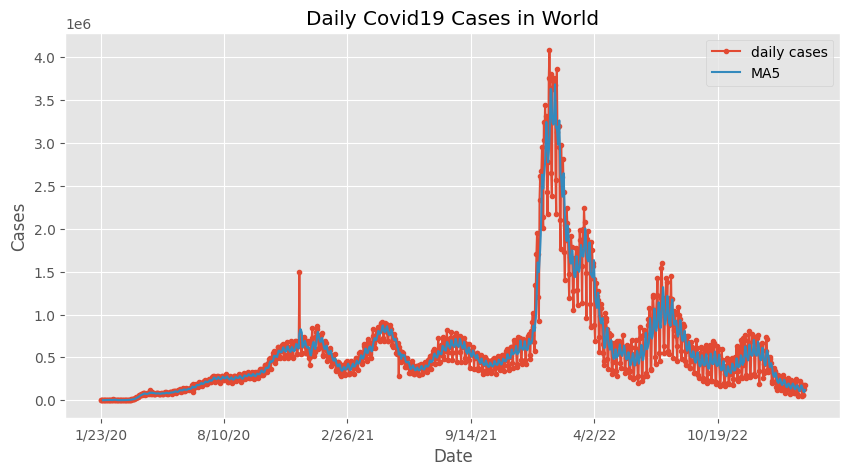

In [ ]:
count = []#loop sum up covid cases for each day across all countries/region
for i in range(1,len(df0)):#range(1, len(df0)): Loops through all rows in the df0 dataframe, starting from the second row (i = 1), as the first row likely contains column names.
    count.append(sum(pd.to_numeric(df0.iloc[i,1:].values)))# df0.iloc[i, 1:]: This accesses the i-th row, starting from the second column onward (ignoring the first column, which is likely the country name).pd.to_numeric(df0.iloc[i, 1:].values): Converts all values from the selected row (except the first column) to numeric, ensuring that any non-numeric values (like text) are handled properly.sum(): Adds up all the numeric values (i.e., the number of cases for each country on a given day).count.append(): Appends the summed total for each row (day) to the count list

df = pd.DataFrame()#Creates a new empty DataFrame
df["Date"] = df0["Country/Region"][1:]#Adds the "Date" column, taking the values from the Country/Region column of df0, starting from the second row ([1:] to skip the first row, which is likely a header).
df["Cases"] = count#Adds the "Cases" column, using the count list computed earlier, which contains the total cases for each day.
df=df.set_index("Date")# Sets the "Date" column as the index of the DataFrame, which makes it easier to perform time-series analysis.

count = []
for i in range(1,len(df1)):
    count.append(sum(pd.to_numeric(df1.iloc[i,1:].values)))#df1.iloc[i, 1:] selects all the death data (excluding the first column), pd.to_numeric() ensures the data is numeric, and sum() adds them up.

df["Deaths"] = count #he count list (which contains the total deaths for each day) is added as a new column called "Deaths" to the df DataFrame.

df.Cases.plot(title="Daily Covid19 Cases in World",marker=".",figsize=(10,5),label="daily cases")#title, marker(use dots to mark each point),size of the plot,label daily case
df.Cases.rolling(window=5).mean().plot(figsize=(10,5),label="MA5")#creates rolling window of 5days. mean of rolling window(smooth out the fluctuations), MA5 labels line as 5 day moving average
plt.ylabel("Cases")
plt.legend()
plt.show()

3. *Daily deaths in the world.*

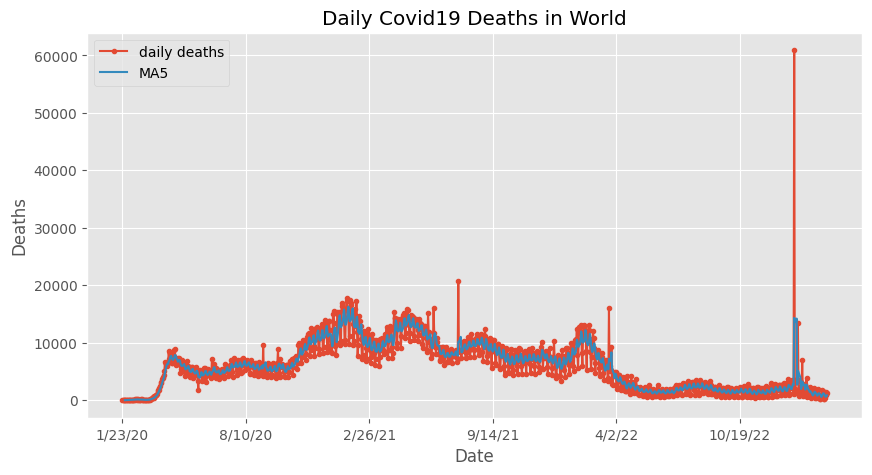

In [ ]:
df.Deaths.plot(title="Daily Covid19 Deaths in World",marker=".",figsize=(10,5),label="daily deaths")
df.Deaths.rolling(window=5).mean().plot(figsize=(10,5),label="MA5")
plt.ylabel("Deaths")
plt.legend()
plt.show()

# Covid-19 Cases Prediction with for Next 30 Days using FB Prophet

<ipython-input-9-51afceefcf76>:21: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtkvxj2e/fh_xb60a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtkvxj2e/u5n9h142.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14230', 'data', 'file=/tmp/tmpdtkvxj2e/fh_xb60a.json', 'init=/tmp/tmpdtkvxj2e/u5n9h142.json', 'output', 'file=/tmp/tmpdtkvxj2e/prophet_modelmpyvlilz/prophet_model-20250111041547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:15:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:15:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


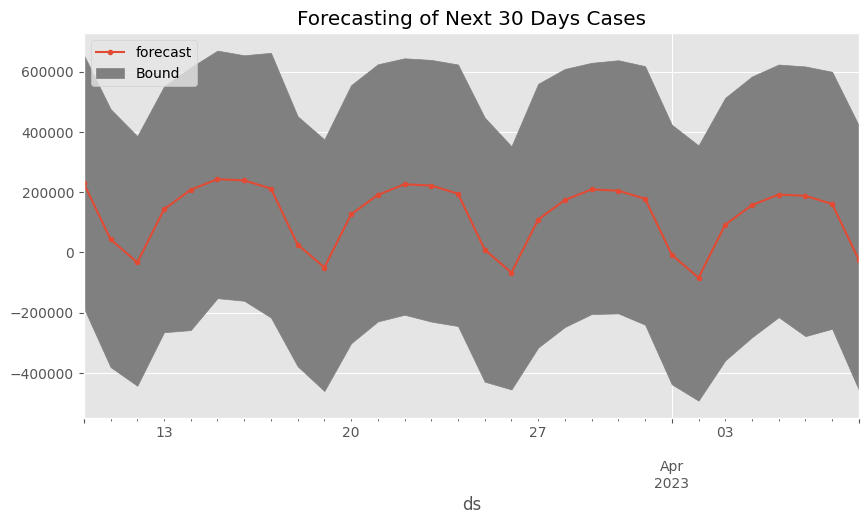

In [ ]:
class Fbprophet(object):#Defines a class named Fbprophet that encapsulates the functionality of the Prophet model (a time series forecasting model).
    def fit(self,data):# fit method initializes the Prophet model and fits it to the provided data.

        self.data  = data#Stores the input data in the class instance as self.data
        self.model = Prophet(weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=False)# Initializes a Prophet model with custom seasonality settings:weekly_seasonality=True: Enables weekly seasonality. disables others due to irrelevance or unnecessary
        self.model.fit(self.data)# Fits the model to the provided data (self.data), learning the patterns for forecasting.

    def forecast(self,periods,freq):# The forecast method generates future predictions using the fitted Prophet model

        self.future = self.model.make_future_dataframe(periods=periods,freq=freq)# Creates a dataframe that extends the original dataset to include future dates. periods specifies the number of future periods to forecast, and freq specifies the frequency (e.g., "D" for daily, "H" for hourly).
        self.df_forecast = self.model.predict(self.future)#Makes predictions for the future (from the extended dataframe) and stores the forecast in self.df_forecast

    def plot(self,xlabel="Years",ylabel="Values"):

        self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))# Plots the forecasted data with custom axis labels (xlabel and ylabel) and a defined figure size (figsize=(9, 4)).
        self.model.plot_components(self.df_forecast,figsize=(9,6))#Plots the individual components of the forecast (e.g., trend, weekly seasonality, etc.).

    def R2(self): #he R2 method computes the R-squared (R²) score, a measure of how well the forecast matches the actual data.
        return r2_score(self.data.y, self.df_forecast.yhat[:len(df)])#Calculates the R-squared score comparing the actual values (self.data.y) with the forecasted values (self.df_forecast.yhat). The forecast is sliced to match the length of the actual data.
df_fb  = pd.DataFrame({"ds":[],"y":[]})#Initializes an empty DataFrame with two columns: ds (date) and y (values).
df_fb["ds"] = pd.to_datetime(df.index)# Sets the ds column as the dates from the index of the original data (df).
df_fb["y"]  = df.iloc[:,0].values# Assigns the first column of df (assumed to be the data values) to the y column in df_fb.

model = Fbprophet()#Creates an instance of the Fbprophet class
model.fit(df_fb)# Fits the model to the prepared data (df_fb)
model.forecast(30,"D")#Generates forecasts for the next 30 days with daily frequency.
model.R2()# Computes the R² score to assess how well the model's predictions match the actual data.

forecast = model.df_forecast[["ds","yhat_lower","yhat_upper","yhat"]].tail(30).reset_index().set_index("ds").drop("index",axis=1)#Extracts the last 30 rows of the forecasted data (for the next 30 days), including the date (ds), the lower bound (yhat_lower), upper bound (yhat_upper), and the forecasted value (yhat).
forecast["yhat"].plot(marker=".",figsize=(10,5))#Plots the forecasted values (yhat) with markers as dots.
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"],color="gray")#Fills the area between the lower and upper bounds to show the uncertainty in the forecast.
plt.legend(["forecast","Bound"],loc="upper left")
plt.title("Forecasting of Next 30 Days Cases")
plt.show()

In [ ]:
# After fitting and forecasting
r2_value = model.R2()
print(f"R² Score: {r2_value}")


R² Score: 0.6850267872612941


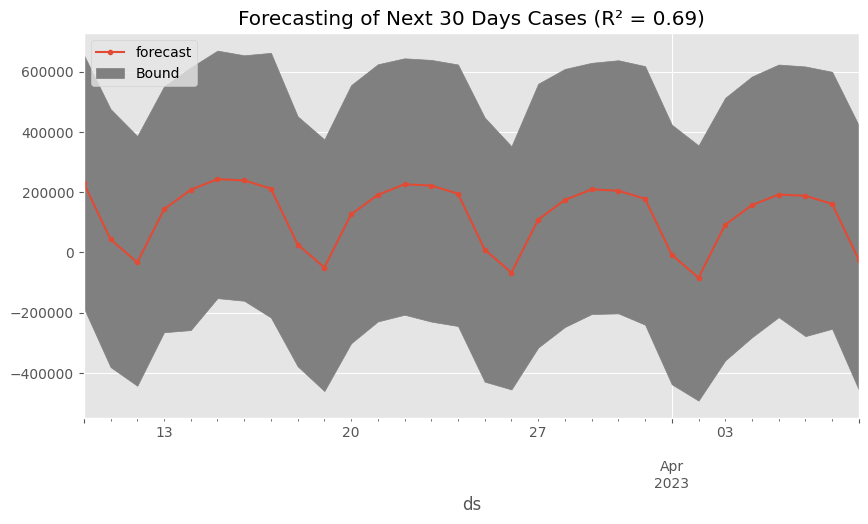

In [ ]:
# Plotting the forecast with R² score in the title
plt.figure(figsize=(10, 5))
forecast["yhat"].plot(marker=".", label="Forecast")
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"], color="gray")
plt.legend(["forecast", "Bound"], loc="upper left")

# Add R² score to the title
plt.title(f"Forecasting of Next 30 Days Cases (R² = {r2_value:.2f})")
plt.show()


The R² (R-squared) value, also called the coefficient of determination, measures how well the model's predictions match the actual data. It indicates the proportion of the variance in the dependent variable that is explained by the independent variables in the model. The R² value ranges from 0 to 1.

Interpreting R² Values:

1.R² = 1: The model perfectly fits the data, and all observed data points lie exactly on the regression line. This is ideal but rare in real-world data.

2.R² = 0: The model explains none of the variance in the dependent variable. The model's predictions are no better than simply using the mean of the dependent variable.

3.R² < 0: This can happen when the model is worse than a simple horizontal line (which is often the case with poorly fitting models). It typically indicates a model that does not fit the data well.
Acceptable R² Value Range:

0.7 to 1.0: Generally, an R² value above 0.7 is considered good, especially in fields like economics, healthcare, and social sciences. The higher the R², the better the model fits the data.

0.5 to 0.7: An R² in this range indicates that the model explains a moderate proportion of the variance. The model can still provide useful insights, but improvements can be made.

0.3 to 0.5: This is a low R², which indicates that the model doesn't explain much of the variance. Further model refinement or feature engineering might be needed.

0 to 0.3: An R² this low suggests that the model is not a good fit for the data and probably needs significant improvements.